In [42]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [43]:
def f(x):
    return 3*x**2 - 4*x + 5

In [44]:
f(3.0)

20.0

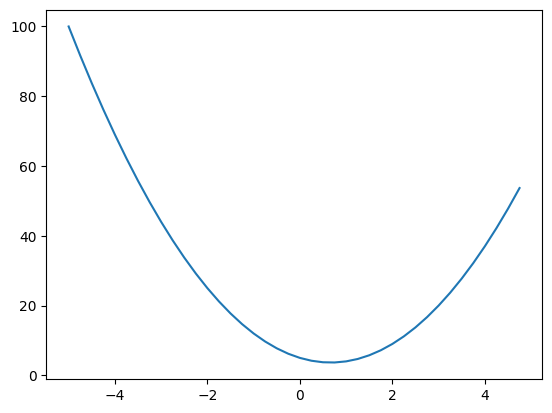

In [45]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [46]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x))/h

2.9753977059954195e-07

In [47]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [48]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

   

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [49]:
# takes a single scalar value that it wraps and keeps track of

class Value: 
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # giving a nice representation when we print and not pointers
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward 
        return out

    def __neg__(self): # negation
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward 
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)) # only supports int/float powers
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * pow(other, -1)

    def tanh(self):
        x = self.data
        exp_2x = math.exp(2 * x)
        t = (exp_2x - 1) / (exp_2x + 1)
        out =  Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward 
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        sorted = []
        visited = set()

        def sort_nodes(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    sort_nodes(child)
                sorted.append(node)
        sort_nodes(self)

        self.grad = 1.0
        for node in reversed(sorted):
            node._backward()

    def reset_grads(self):
        sorted = []
        visited = set()

        def sort_nodes(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    sort_nodes(child)
                sorted.append(node)
        sort_nodes(self)

        self.grad = 1.0
        for node in reversed(sorted):
            for child in node._prev:
                child.grad = 0.0
            

# forward pass
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f
L.label = 'L'
L
# above equivalent to (a.__mul__(b)).__add__(c)

Value(data=-8.0)

In [50]:
a = Value(3.0)

b = -a

In [51]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f  }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

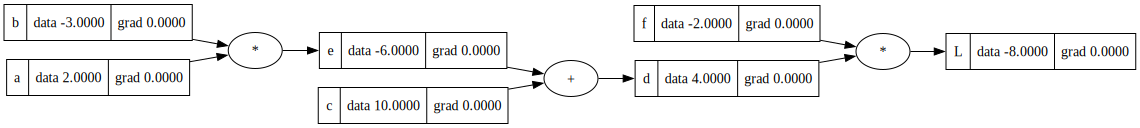

In [52]:
draw_dot(L)

Next up, we are going to implement backprop, specifically we are going to find the derivaties of L with respect to the other variables in the graph.

In [53]:
L.grad = 1.0

f.grad = 4.0
d.grad = -2.0

c.grad = -2.0
e.grad = -2.0

a.grad = 6.0
b.grad = -4.0

In [54]:
# nudge in the direction of the gradient at each node to make L more positive
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# do one new forward pass
e = a * b
d = e + c
L = d * f

# we expect L to become more positive
print(L.data)

-1.328096


In [55]:
def lol():
    h = 0.0001

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0 + h, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()


-4.000000000008441


* plus node's local derivate is 1 -> routes the gradient to the previous nodes
* multiply node's local derivative is the value of the other node

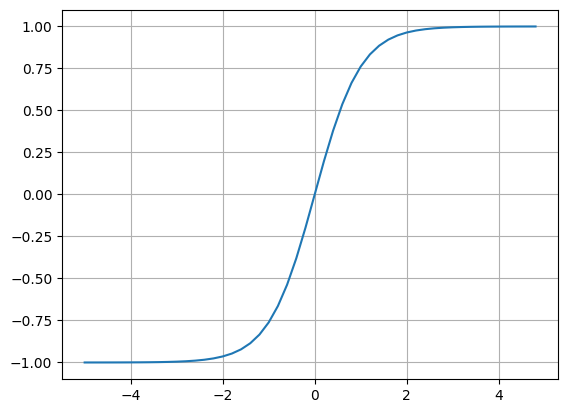

In [56]:
# activation function for a neuron, remember its between -1 and 1 though

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

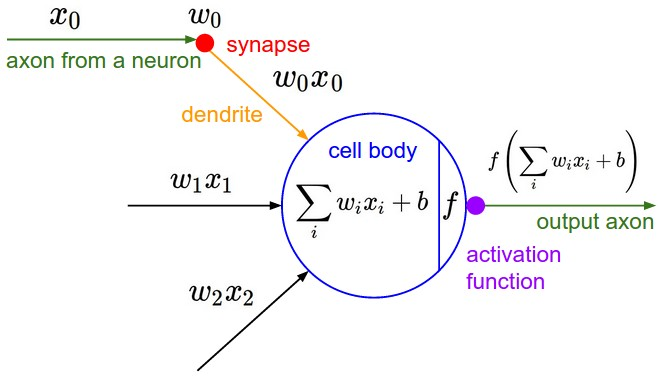

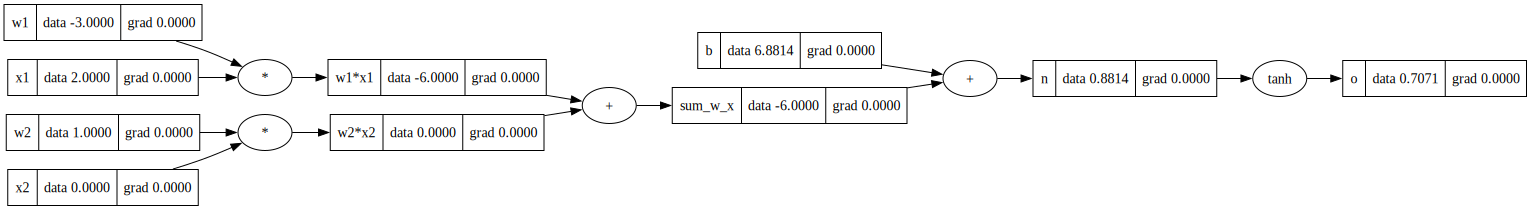

In [57]:
# manual forward pass
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2 (synaptic strength of each input)
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# cell body equation, sum of w_i*x_i + b
w1x1 = w1*x1; w1x1.label = 'w1*x1'
w2x2 = w2*x2; w2x2.label = 'w2*x2'

sum_w_x = w1x1 + w2x2; sum_w_x.label = 'sum_w_x'

# n for neuron
n = sum_w_x + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# draw after manual forward pass
draw_dot(o)

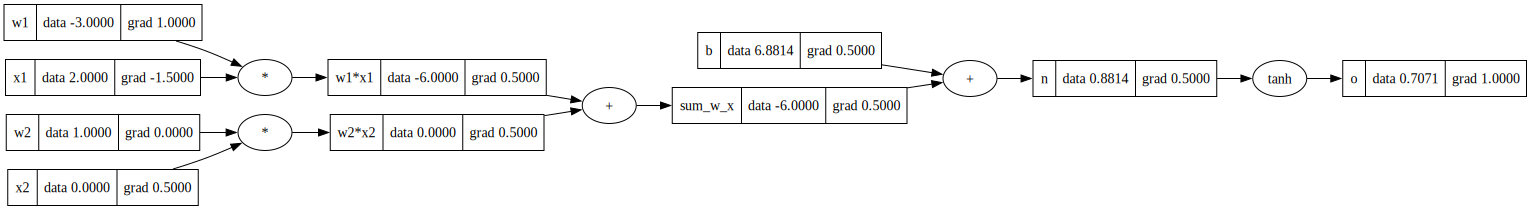

In [58]:
# manual backward pass (backprop)
# do/do = 1
o.grad = 1

# do/dn =  1 - tanh(n)**2 = 1 - o**2;
n.grad = 1 - o.data**2

# do/d(sum_w_x) = do/dn * 1 (local derivative of plus node is 1)
sum_w_x.grad = n.grad * 1
b.grad = n.grad * 1

# same distribution of gradient back through a plus node, local derivative is 1
w1x1.grad = sum_w_x.grad * 1
w2x2.grad = sum_w_x.grad * 1

# now we go through two multiply nodes, local derivative of a multiply node is the other node
# remember we take the "current" gradient and multiply it by the local derivative of the operation
x1.grad = w1x1.grad * w1.data
x2.grad = w2x2.grad * w2.data

w1.grad = w1x1.grad * x1.data
w2.grad = w2x2.grad * x2.data

# draw after manual backward pass
draw_dot(o)

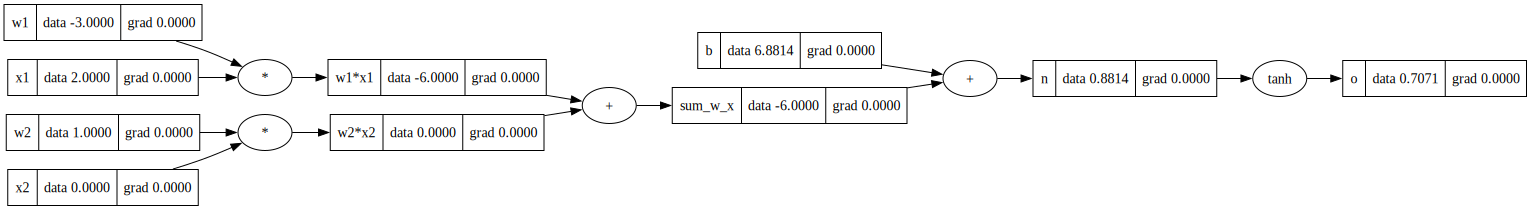

In [59]:
# reset gradients to 0 to do ._backward() pass
o.grad = 0; n.grad = 0; b.grad = 0; sum_w_x.grad = 0; w2x2.grad = 0; w1x1.grad = 0; x2.grad = 0; w2.grad = 0; x1.grad = 0; w1.grad = 0;

# draw to check grads are 0
draw_dot(o)

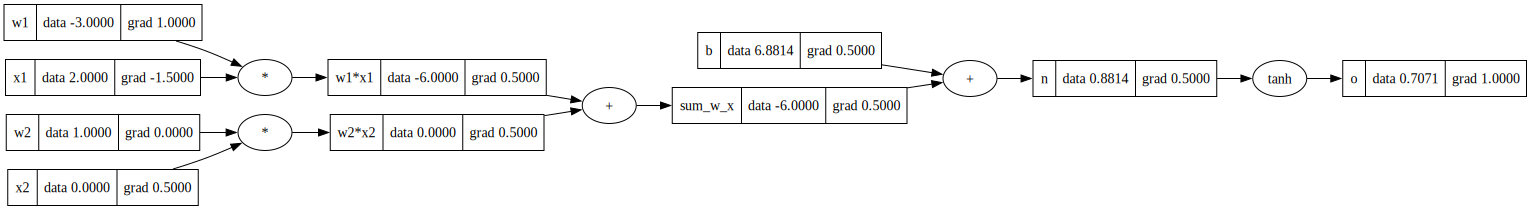

In [60]:
# step-by-step "automatic" backprop
# initialise o.grad = 1, as it's currently 0 and that will mean all gradients will 0 automatically after backprop
o.grad = 1.0;

o._backward(); n._backward(); sum_w_x._backward(); w1x1._backward(); w2x2._backward(); 

draw_dot(o)

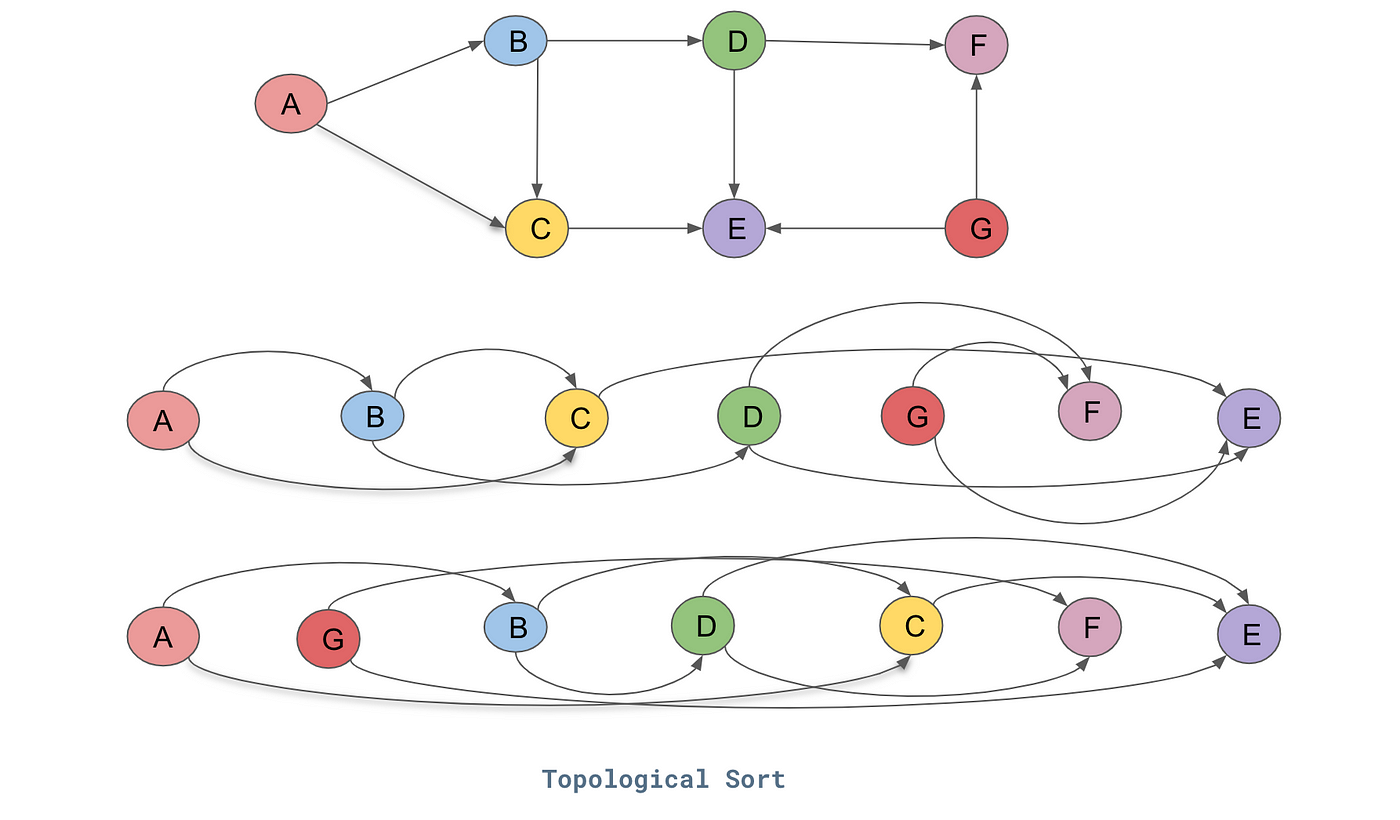

In [61]:
# topological sort
# remember that self._prev in Value class is: set(_children)

sorted = []
visited = set()

def sort_nodes(node):
    if node not in visited:
        visited.add(node)
        for child in node._prev:
            sort_nodes(child)
        sorted.append(node)

sort_nodes(o)

# print labels in order
for node in sorted:
    print(node.label)

b
w2
x2
w2*x2
w1
x1
w1*x1
sum_w_x
n
o


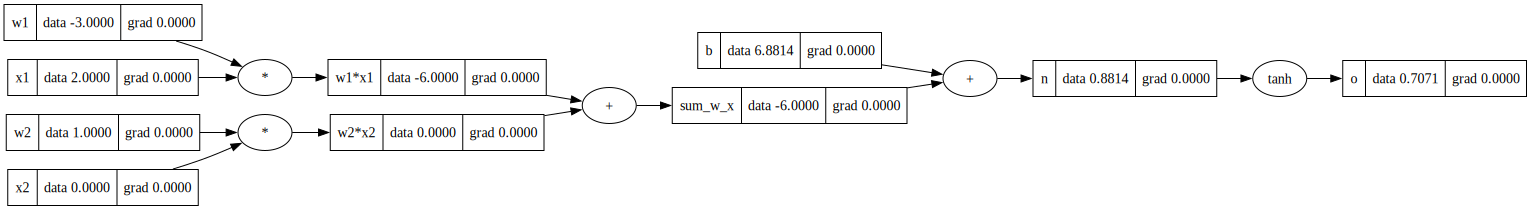

In [62]:
# reset gradients to 0 to do automatic ._backward() pass based on topological sort
o.grad = 0; n.grad = 0; b.grad = 0; sum_w_x.grad = 0; w2x2.grad = 0; w1x1.grad = 0; x2.grad = 0; w2.grad = 0; x1.grad = 0; w1.grad = 0;

# draw to check grads are 0
draw_dot(o)

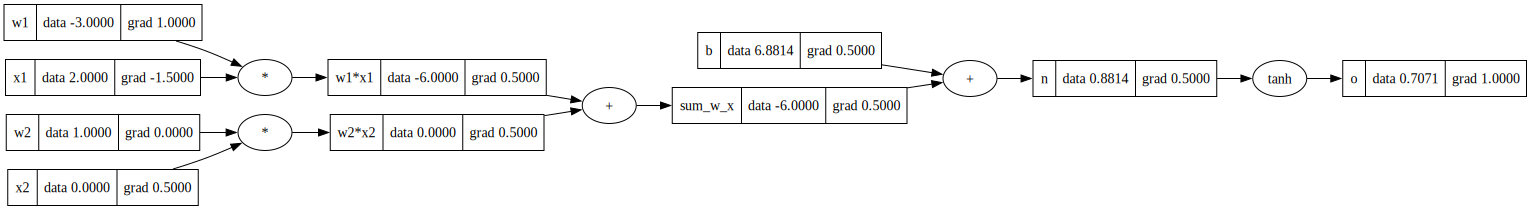

In [63]:
o.grad = 1.0

for node in reversed(sorted):
    node._backward()

# draw to check grads are set
draw_dot(o)


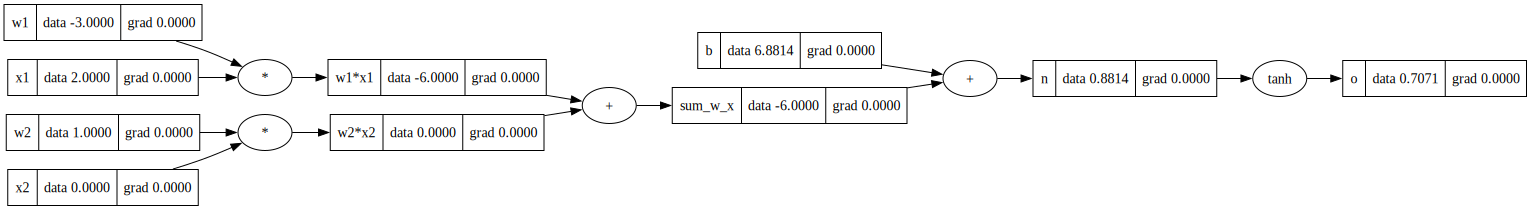

In [64]:
# reset gradients to 0 to do automatic ._backward() pass based on topological sort
o.grad = 0; n.grad = 0; b.grad = 0; sum_w_x.grad = 0; w2x2.grad = 0; w1x1.grad = 0; x2.grad = 0; w2.grad = 0; x1.grad = 0; w1.grad = 0;

# draw to check grads are 0
draw_dot(o)

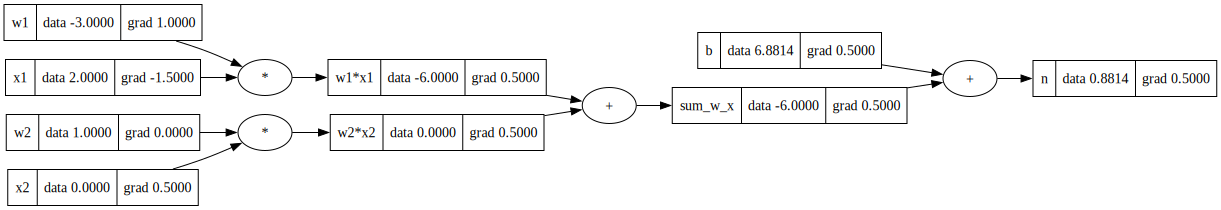

In [65]:
o.backward()
draw_dot(n) 

# what I don't understand here, is why n has grad 0.5 and not 1.0, even though we set 
# self.grad = 1.0 here!! oh becasuse we start with o.backward and truncate the graph at n. 
# so it will be 1.0 if we set to 0, run n.backward and draw_dot(n), let's try below 👇

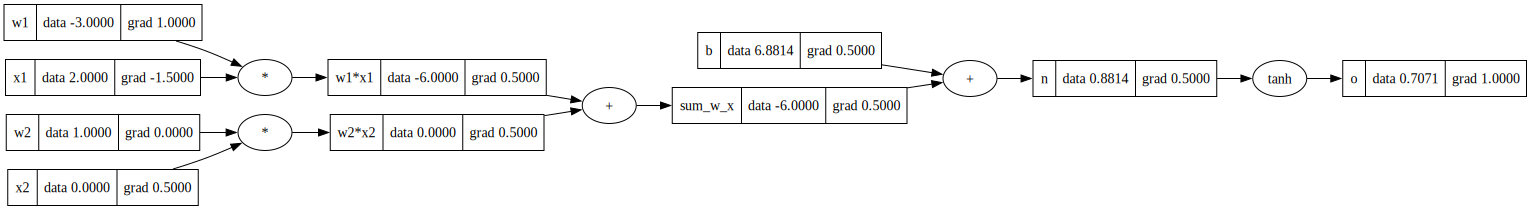

In [66]:
draw_dot(o)

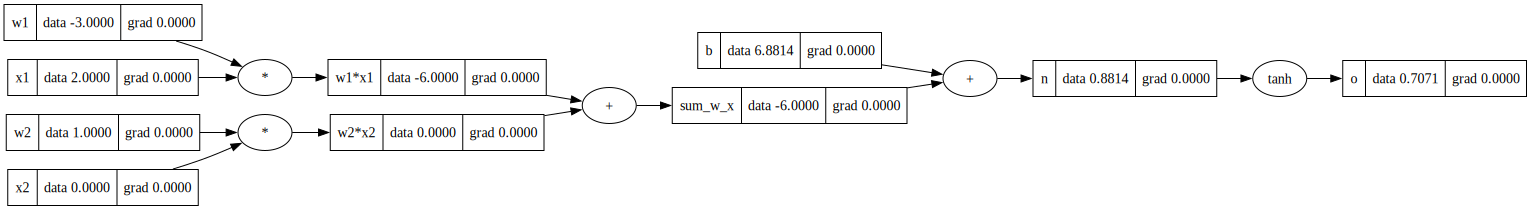

In [67]:
# reset gradients to 0 to do automatic ._backward() pass based on topological sort
o.grad = 0; n.grad = 0; b.grad = 0; sum_w_x.grad = 0; w2x2.grad = 0; w1x1.grad = 0; x2.grad = 0; w2.grad = 0; x1.grad = 0; w1.grad = 0;

# draw to check grads are 0
draw_dot(o)

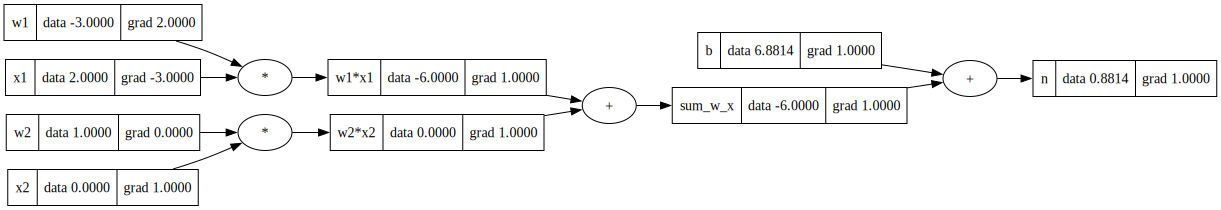

In [68]:
n.backward()
draw_dot(n)

Nice one!! I had started to build a reset grads function, where we can call it on a value and it will reset all the grads in the dependency tree before it, i.e. a backprop for setting grads to 0; intended use - o.reset_grads(), which would set o.grad = 1.0 and the rest to 0.

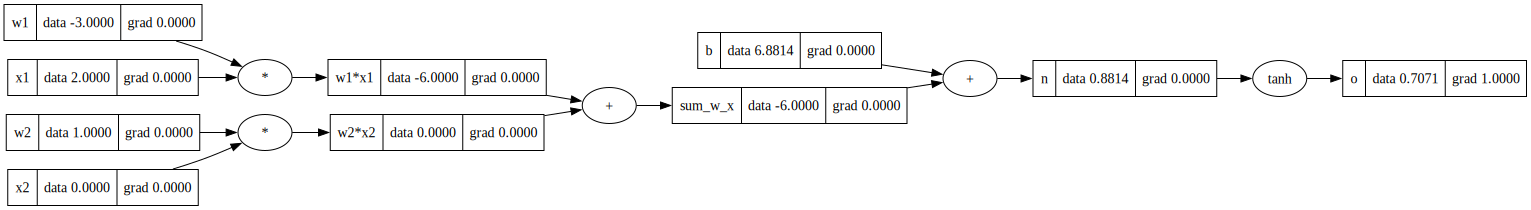

In [69]:
o.reset_grads()
draw_dot(o)

In [ ]:
o.grad = 1.0
draw_dot(o)

# something is wrong here, I can't really be bothered to track it all through as I rewrote this all from memory in organised_video_1.pynb. I think I haven't reset grads properly or something and it's accumulating extra 1 from the start adding a lot of gradient across the network where it shouldn't be


AttributeError: 'Tensor' object has no attribute '_prev'

Got reset_grads() to work fuck yeah, next part Andrej is talking about a backprop bug, intriguiung

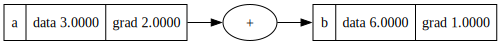

In [71]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'

b.backward()
draw_dot(b)


In [72]:
a =  Value(2.0)
b = Value(1.0)

a - b

Value(data=1.0)

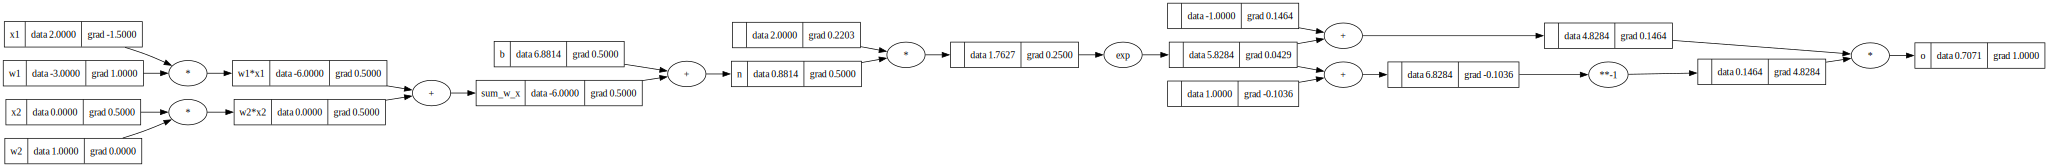

In [73]:
# okay, we have implemented even more things from scratch, including pow(), exp(), subtraction, division, negation etc.
# Now we want to build tanh manually from these lower level functions, instead of relying on tanh() directly I think
# Ah! We are breaking up the atomic tanh into all of its individual operations (kind of, we don't necessarily have a node for e-1 and e + 1, but we could)

# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2 (synaptic strength of each input)
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# cell body equation, sum of w_i*x_i + b
w1x1 = w1*x1; w1x1.label = 'w1*x1'
w2x2 = w2*x2; w2x2.label = 'w2*x2'
sum_w_x = w1x1 + w2x2; sum_w_x.label = 'sum_w_x'

n = sum_w_x + b; n.label = 'n'
e = (2*n).exp() # calling Value.exp() here
o = (e - 1)/(e + 1); o.label = 'o'

o.backward()
draw_dot(o)

This was all an exercise in understanding that it doesn't matter how deep you go on the breaking up of operations.

In [74]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
print(type(o.data.item))
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
<class 'builtin_function_or_method'>
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [75]:
# now in tinygrad
from tinygrad import Tensor
from tinygrad import dtypes

x1 =  Tensor([2.0], dtype=dtypes.float32, requires_grad=True)
x2 =  Tensor([0.0], dtype=dtypes.float32, requires_grad=True)
w1 =  Tensor([-3.0], dtype=dtypes.float32, requires_grad=True)
w2 =  Tensor([1.0], dtype=dtypes.float32, requires_grad=True)
b =   Tensor([6.8813735870195432], dtype=dtypes.float32, requires_grad=True)

n = x1*w1 + x2*w2 + b; n.requires_grad = True
o = n.tanh(); o.requires_grad = True
o.sum().backward()
print('x2', x2.grad.numpy())
print('w2', w2.grad.numpy())
print('x1', x1.grad.numpy())
print('w1', w1.grad.numpy())


x2 [0.5000001]
w2 [0.]
x1 [-1.5000004]
w1 [1.0000002]


In [76]:
class Value: 
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # giving a nice representation when we print and not pointers
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward 
        return out

    def __neg__(self): # negation
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward 
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)) # only supports int/float powers
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * pow(other, -1)

    def tanh(self):
        x = self.data
        exp_2x = math.exp(2 * x)
        t = (exp_2x - 1) / (exp_2x + 1)
        out =  Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward 
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        sorted = []
        visited = set()

        def sort_nodes(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    sort_nodes(child)
                sorted.append(node)
        sort_nodes(self)

        self.grad = 1.0
        for node in reversed(sorted):
            node._backward()

    def reset_grads(self):
        sorted = []
        visited = set()

        def sort_nodes(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    sort_nodes(child)
                sorted.append(node)
        sort_nodes(self)

        self.grad = 1.0
        for node in reversed(sorted):
            for child in node._prev:
                child.grad = 0.0

In [77]:
# NNs are a specific class of mathematical expressions
# NNs in tinygrad are represented by operations performed on tensors
import random

class Neuron:
    def __init__(self, no_inputs):
        self.weights = [Value(random.uniform(-1,1)) for _ in range(no_inputs)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        activation = sum((wi*xi for wi, xi in zip(self.weights, x)), self.b)
        out = activation.tanh()
        return out

x = [2.0, 3.0]
n = Neuron(3)
n(x)

Value(data=-0.7359462500248476)

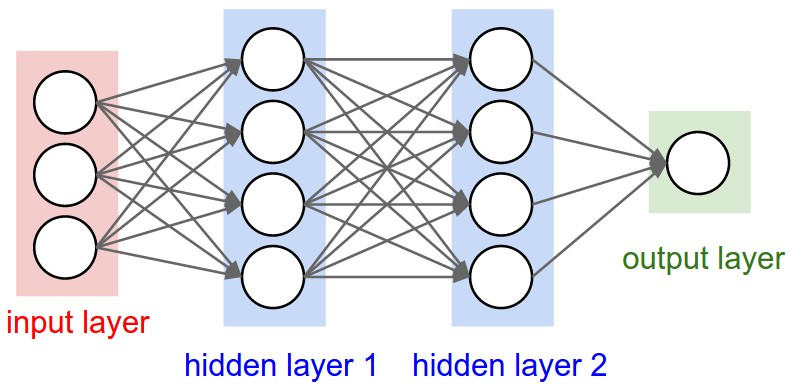

interestingly, all nodes in the first layer are fully connected to all inputs

In [78]:
class Layer:
    def __init__(self, no_inputs, no_ouputs):
        self.neurons = [Neuron(no_inputs) for _ in range(no_ouputs)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

x = [2.0, 3.0]
n = Layer(2, 3)
n(x)


[Value(data=0.17460484838179957),
 Value(data=-0.9516831716048333),
 Value(data=-0.5372713371858743)]

In [79]:
class MLP:
    def __init__(self, no_inputs, no_outputs):
        

_IncompleteInputError: incomplete input (3730352673.py, line 3)